In [1]:
# Full cleaned notebook for IPSA project: Brain MRI classification (4 classes)
# Paste into a Jupyter notebook cell or save as a .py and run (adjust paths as needed).

Brain MRI Classification — full pipeline: load -> EDA -> preprocessing -> model -> eval -> visualizations

In [2]:
import os
import shutil
import pathlib
import time
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score, log_loss,
                             balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
                             jaccard_score, hamming_loss, zero_one_loss)

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Modules loaded")

2025-10-03 10:09:29.180244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759486169.365114      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759486169.416606      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules loaded


### Configuration - adjust paths & parameters here

In [3]:
# Path to dataset (change if different)
DATA_PATH = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training"

# Image target size
IMG_SIZE = (128, 128)   # (width, height)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# Output artifacts
BEST_MODEL_PATH = "best_model.h5"
HISTORY_PLOT = "training_history.png"
METRICS_CSV = "evaluation_metrics.csv"

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load dataset paths & simple metadata (no heavy image loading yet)

In [4]:
images = []
labels = []
img_sizes = []
img_modes = []

# iterate folders
for subfolder in sorted(os.listdir(DATA_PATH)):
    subfolder_path = os.path.join(DATA_PATH, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for fname in sorted(os.listdir(subfolder_path)):
        image_path = os.path.join(subfolder_path, fname)
        try:
            with Image.open(image_path) as img:
                img_sizes.append(img.size)
                img_modes.append(img.mode)
            images.append(image_path)
            labels.append(subfolder)
        except Exception as e:
            print("Skipping file (error):", image_path, e)

data_df = pd.DataFrame({
    'image_path': images,
    'label': labels,
    'image_size': img_sizes,
    'image_mode': img_modes
})

print("Total images:", len(data_df))
print("Classes:", sorted(data_df['label'].unique()))
print(data_df['label'].value_counts())

Total images: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


### Quick EDA - sample images, size distribution, class distribution

/tmp/ipykernel_19/1618133936.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('label').apply(lambda x: x.sample(min(n_per_class, len(x)))).reset_index(drop=True)


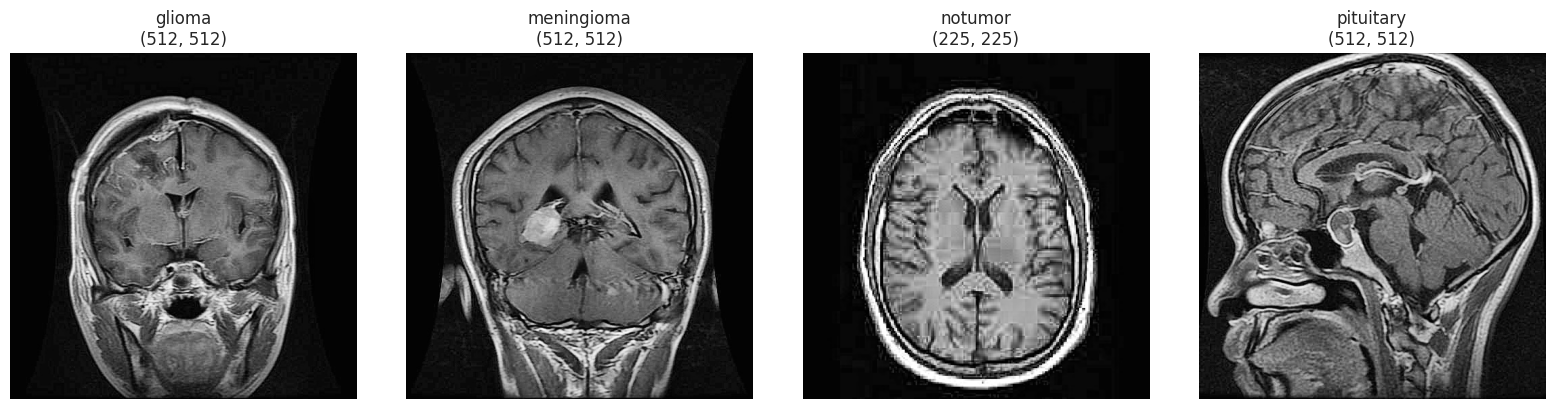

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


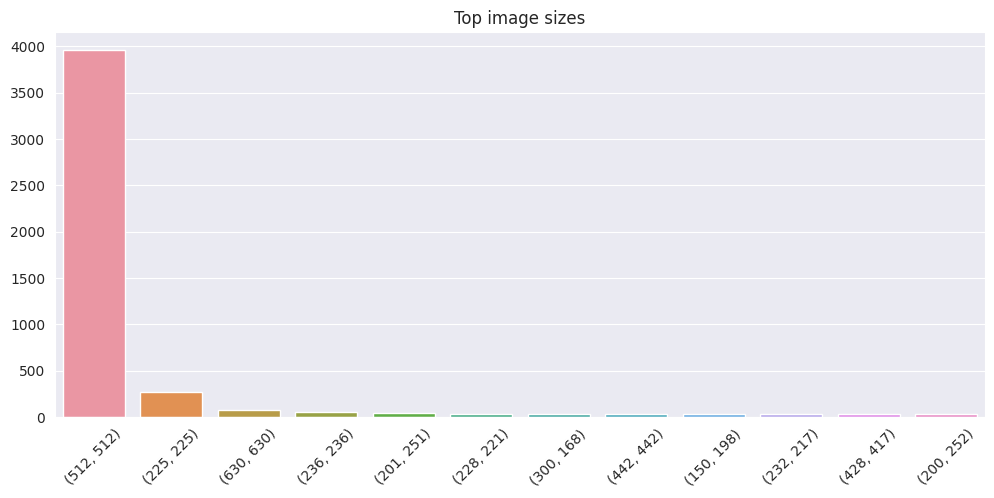

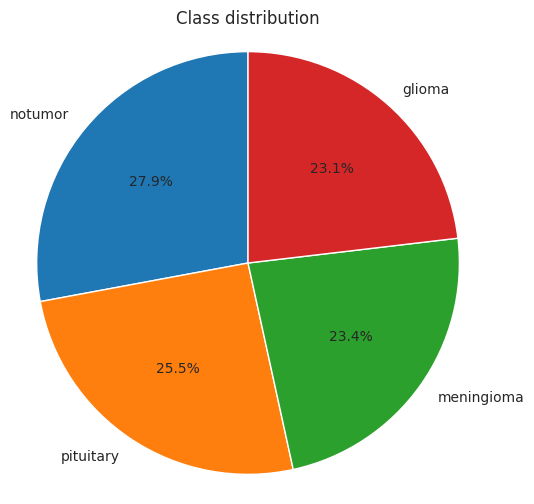

In [5]:
def display_sample_images(df, n_per_class=1):
    sampled = df.groupby('label').apply(lambda x: x.sample(min(n_per_class, len(x)))).reset_index(drop=True)
    n = len(sampled)
    cols = min(4, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    axes = axes.reshape(-1)
    for ax_idx, (_, row) in enumerate(sampled.iterrows()):
        ax = axes[ax_idx]
        img = Image.open(row['image_path']).convert('L')
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{row['label']}\n{img.size}")
        ax.axis('off')
    # hide extras
    for i in range(len(sampled), len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(data_df, n_per_class=1)

# sizes distribution
plt.figure(figsize=(12,5))
top_sizes = data_df['image_size'].value_counts().head(12)
sns.barplot(x=[str(x) for x in top_sizes.index], y=top_sizes.values)
plt.xticks(rotation=45)
plt.title("Top image sizes")
plt.show()

# class distribution
plt.figure(figsize=(6,6))
counts = data_df['label'].value_counts()
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Class distribution")
plt.axis('equal')
plt.show()

### Preprocess images (resize, normalize) and prepare train/val/test splits

In [6]:
# Load, convert to grayscale, resize, normalize
X_list = []
y_list = []

for idx, row in data_df.iterrows():
    try:
        img = Image.open(row['image_path']).convert('L')
        img = img.resize(IMG_SIZE)
        arr = np.array(img, dtype=np.float32) / 255.0
        arr = np.expand_dims(arr, axis=-1)  # (H, W, 1)
        X_list.append(arr)
        y_list.append(row['label'])
    except Exception as e:
        print("Error loading image:", row['image_path'], e)

X = np.array(X_list)
y = np.array(y_list)
print("X shape:", X.shape, "y shape:", y.shape)

# encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("Classes mapped:", list(zip(le.classes_, range(num_classes))))
y_cat_all = to_categorical(y_encoded, num_classes=num_classes)

# splits: train/val/test with stratify
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# compute class weights for imbalanced classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {int(i): float(w) for i, w in enumerate(cw)}
print("Class weights:", class_weights)

X shape: (5712, 128, 128, 1) y shape: (5712,)
Classes mapped: [('glioma', 0), ('meningioma', 1), ('notumor', 2), ('pituitary', 3)]
Train: (4569, 128, 128, 1) Val: (571, 128, 128, 1) Test: (572, 128, 128, 1)
Class weights: {0: 1.0806527909176915, 1: 1.0665266106442577, 2: 0.895180250783699, 3: 0.9804721030042919}


### Data augmentation generator

In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# fit generator if needed (not necessary for simple augmentation but kept)
# datagen.fit(X_train)

### Build CNN model (cleaned Dropout usage & reasonable architecture)

In [8]:
def build_model(input_shape=(128,128,1), num_classes=4):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4)))
    return model

model = build_model(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 1), num_classes=num_classes)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1759486225.398824      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,495,556 (9.52 MB)

 Trainable params: 2,494,596 (9.52 MB)

 Non-trainable params: 960 (3.75 KB)

### Optional: visualize model architecture (visualkeras). Try to install if available.

In [9]:
try:
    import visualkeras
    try:
        visualkeras.layered_view(model, to_file='/kaggle/working/model_visual.png', legend=True, draw_volume=True)
        print("Saved model_visual.png")
    except Exception as e:
        print("visualkeras call failed:", e)
except Exception as e:
    print("visualkeras not installed or failed to import. (Optional for architecture image)")

visualkeras not installed or failed to import. (Optional for architecture image)


### Callbacks & training

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1759486232.559303      62 service.cc:148] XLA service 0x7beb500178d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759486232.560054      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759486233.186139      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759486239.779785      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.25569, saving model to best_model.h5
142/142 - 27s - 190ms/step - accuracy: 0.4812 - loss: 1.4859 - val_accuracy: 0.2557 - val_loss: 2.1539 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.25569
142/142 - 0s - 1ms/step - accuracy: 0.6250 - loss: 1.0142 - val_accuracy: 0.2557 - val_loss: 2.1403 - learning_rate: 0.0010
Epoch 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_accuracy did not improve from 0.25569
142/142 - 6s - 44ms/step - accuracy: 0.5867 - loss: 1.0261 - val_accuracy: 0.2487 - val_loss: 4.6530 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.25569
142/142 - 0s - 948us/step - accuracy: 0.5625 - loss: 1.0868 - val_accuracy: 0.2487 - val_loss: 4.6205 - learning_rate: 0.0010
Epoch 5/30

Epoch 5: val_accuracy improved from 0.25569 to 0.30823, saving model to best_model.h5
142/142 - 6s - 44ms/step - accuracy: 0.6447 - loss: 0.9527 - val_accuracy: 0.3082 - val_loss: 4.9021 - learning_rate: 0.0010
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_accuracy improved from 0.30823 to 0.31699, saving model to best_model.h5
142/142 - 0s - 2ms/step - accuracy: 0.7188 - loss: 0.6778 - val_accuracy: 0.3170 - val_loss: 4.9263 - learning_rate: 0.0010
Epoch 7/30

Epoch 7: val_accuracy improved from 0.31699 to 0.48511, saving model to best_model.h5
142/142 - 6s 

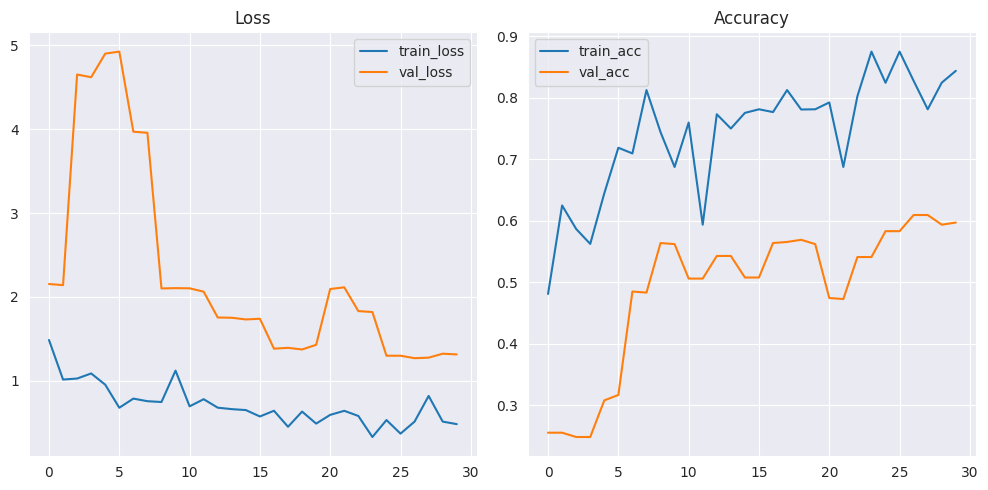

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(BEST_MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# train
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, seed=SEED),
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights,
    verbose=2
)

# save history plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.savefig(HISTORY_PLOT)
plt.show()

### Load best model (if checkpoint saved) and evaluate on test set

In [11]:
# If checkpoint exists, load it to ensure best weights
if os.path.exists(BEST_MODEL_PATH):
    model.load_weights(BEST_MODEL_PATH)
    print("Loaded best model weights from", BEST_MODEL_PATH)

test_loss, test_accuracy = model.evaluate(X_test, to_categorical(y_test, num_classes=num_classes), verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

Loaded best model weights from best_model.h5
Test loss: 1.2903, Test accuracy: 0.6014
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [12]:
# Compute many metrics
metrics = {}
metrics['Accuracy'] = accuracy_score(y_true, y_pred)
metrics['Precision (Macro)'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
metrics['Recall (Macro)'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
metrics['F1-Score (Macro)'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
metrics['Precision (Weighted)'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
metrics['Recall (Weighted)'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
metrics['F1-Score (Weighted)'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
metrics['Cohen Kappa'] = cohen_kappa_score(y_true, y_pred)
metrics['Matthews Corr'] = matthews_corrcoef(y_true, y_pred)
metrics['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
metrics['Jaccard (Macro)'] = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
metrics['Hamming Loss'] = hamming_loss(y_true, y_pred)
metrics['Zero-One Loss'] = zero_one_loss(y_true, y_pred)

# ROC & PR AUC per class
y_test_bin = to_categorical(y_true, num_classes=num_classes)
roc_aucs = []
pr_aucs = []
for i in range(num_classes):
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_aucs.append(auc(fpr, tpr))
    except Exception:
        roc_aucs.append(np.nan)
    try:
        pr_aucs.append(average_precision_score(y_test_bin[:, i], y_pred_probs[:, i]))
    except Exception:
        pr_aucs.append(np.nan)

metrics['ROC AUC (Macro)'] = np.nanmean(roc_aucs)
metrics['PR AUC (Macro)'] = np.nanmean(pr_aucs)

# log loss
try:
    metrics['Log Loss'] = log_loss(y_test_bin, y_pred_probs)
except Exception as e:
    metrics['Log Loss'] = np.nan

metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric','Value'])
print("\nEvaluation metrics:")
print(metrics_df.round(4))

# save metrics to CSV
metrics_df.to_csv(METRICS_CSV, index=False)
print("Saved metrics to", METRICS_CSV)


Evaluation metrics:
                  Metric   Value
0               Accuracy  0.6014
1      Precision (Macro)  0.7182
2         Recall (Macro)  0.5737
3       F1-Score (Macro)  0.4968
4   Precision (Weighted)  0.7093
5      Recall (Weighted)  0.6014
6    F1-Score (Weighted)  0.5130
7            Cohen Kappa  0.4586
8          Matthews Corr  0.5146
9      Balanced Accuracy  0.5737
10       Jaccard (Macro)  0.3688
11          Hamming Loss  0.3986
12         Zero-One Loss  0.3986
13       ROC AUC (Macro)  0.9179
14        PR AUC (Macro)  0.7902
15              Log Loss  1.2500
Saved metrics to evaluation_metrics.csv


### Confusion matrix & classification report

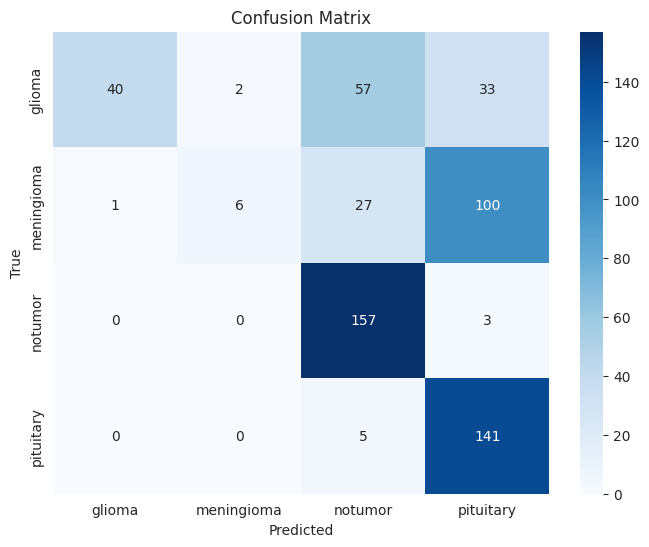


Classification report:
              precision    recall  f1-score   support

      glioma       0.98      0.30      0.46       132
  meningioma       0.75      0.04      0.08       134
     notumor       0.64      0.98      0.77       160
   pituitary       0.51      0.97      0.67       146

    accuracy                           0.60       572
   macro avg       0.72      0.57      0.50       572
weighted avg       0.71      0.60      0.51       572



In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

### ROC curves & Precision-Recall curves (per-class)

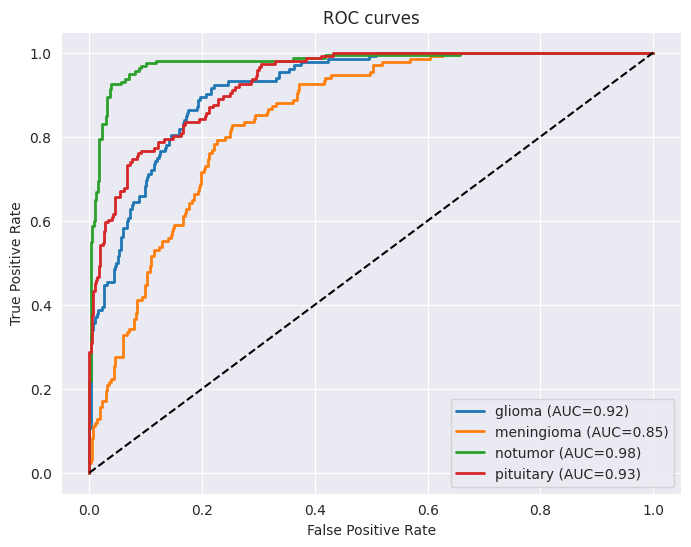

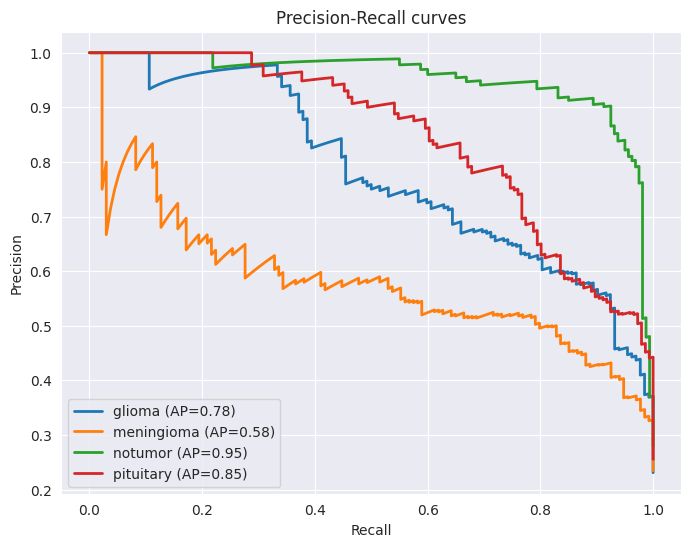

In [14]:
plt.figure(figsize=(8,6))
for i in range(num_classes):
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")
    except Exception:
        pass
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8,6))
for i in range(num_classes):
    try:
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
        pr_auc = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f"{le.classes_[i]} (AP={pr_auc:.2f})")
    except Exception:
        pass
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves")
plt.legend(loc='best')
plt.show()

### Class-wise bar chart (precision/recall/f1)

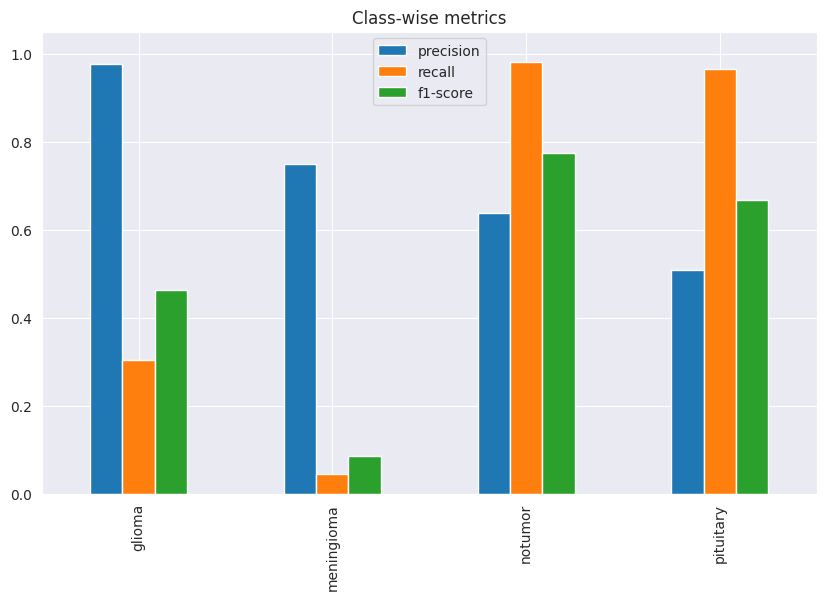

In [15]:
class_report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
class_metrics = pd.DataFrame(class_report).transpose().iloc[:num_classes][['precision','recall','f1-score']]

class_metrics.plot(kind='bar', figsize=(10,6))
plt.title("Class-wise metrics")
plt.ylim(0,1.05)
plt.show()

### Visualize activations of first few conv layers for one sample image

Model built with input shape: (None, 128, 128, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


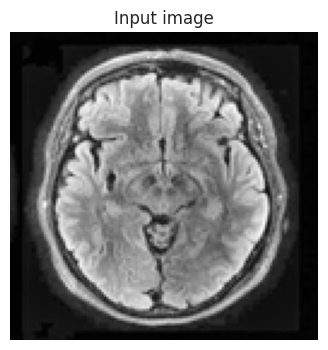

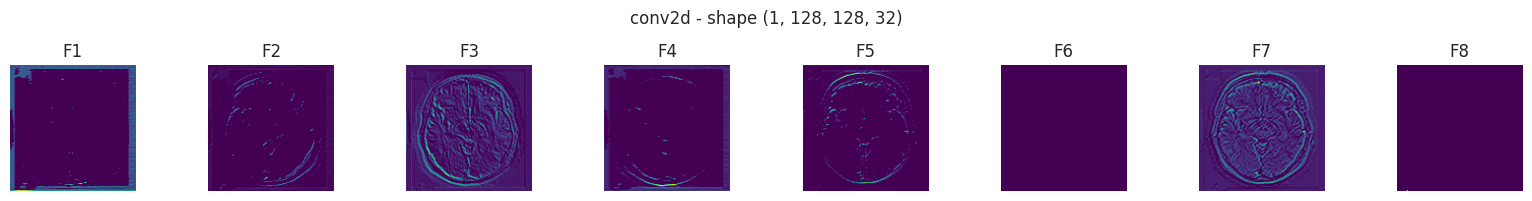

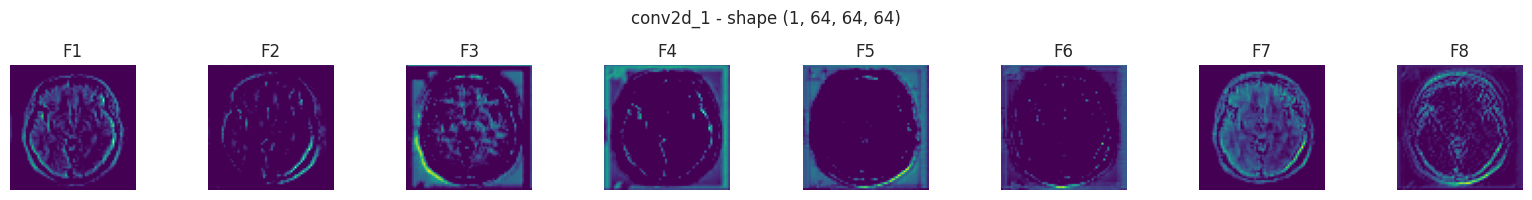

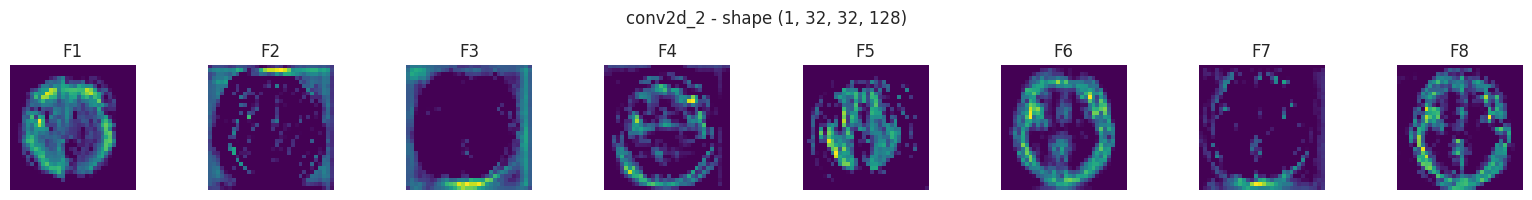

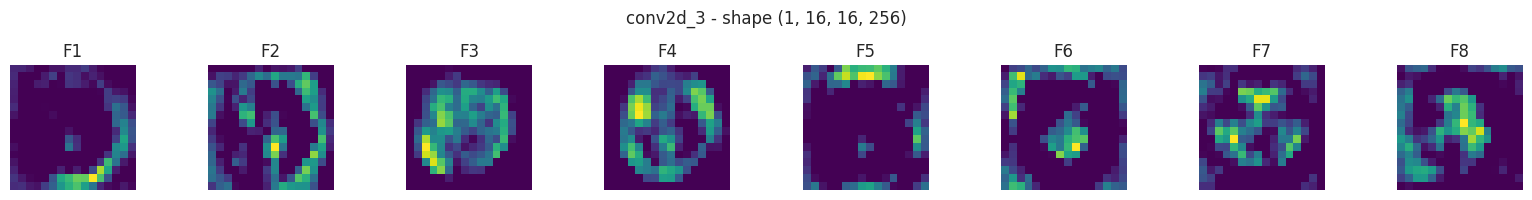

In [16]:
def activation_view(model, sample_image, max_layers=4, max_filters=8):
    # Robust activation viewer: ensures model is built and then creates intermediate model
    try:
        _ = model.input
    except Exception:
        # build model if not built (use IMG_SIZE if defined)
        try:
            h, w = IMG_SIZE[1], IMG_SIZE[0]
        except Exception:
            h, w = sample_image.shape[1], sample_image.shape[2]
        model.build(input_shape=(None, h, w, sample_image.shape[-1]))
        print("Model built with input shape:", (None, h, w, sample_image.shape[-1]))
    
    conv_outputs = []
    conv_names = []
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            conv_outputs.append(layer.output)
            conv_names.append(layer.name)
        if len(conv_outputs) >= max_layers:
            break

    if len(conv_outputs) == 0:
        print("No Conv2D layers found in model.")
        return

    intermediate_model = tf.keras.Model(inputs=model.inputs, outputs=conv_outputs)
    activations = intermediate_model.predict(sample_image)

    # show input
    plt.figure(figsize=(4,4))
    if sample_image.shape[-1] == 1:
        plt.imshow(sample_image[0,:,:,0], cmap='gray')
    else:
        plt.imshow(sample_image[0])
    plt.title("Input image")
    plt.axis('off')
    plt.show()

    for idx, act in enumerate(activations):
        n_filters = min(max_filters, act.shape[-1])
        fig, axes = plt.subplots(1, n_filters, figsize=(2*n_filters, 2))
        if n_filters == 1:
            axes = [axes]
        for i in range(n_filters):
            fmap = act[0, :, :, i]
            fmap_min, fmap_max = fmap.min(), fmap.max()
            if fmap_max - fmap_min > 1e-6:
                fmap = (fmap - fmap_min) / (fmap_max - fmap_min)
            axes[i].imshow(fmap, cmap='viridis')
            axes[i].set_title(f'F{i+1}')
            axes[i].axis('off')
        plt.suptitle(f"{conv_names[idx]} - shape {act.shape}")
        plt.tight_layout()
        plt.show()

# pick a sample
sample_idx = 0
sample_img = X_test[sample_idx:sample_idx+1]
activation_view(model, sample_img)

### Save final model (if not already saved)

In [17]:
if not os.path.exists(BEST_MODEL_PATH):
    model.save(BEST_MODEL_PATH)
    print("Saved model to", BEST_MODEL_PATH)
else:
    print("Model checkpoint is present at", BEST_MODEL_PATH)

print("Done.")

Model checkpoint is present at best_model.h5
Done.
